In [132]:
import numpy as np

#extra imports
import sympy as sm
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [154]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [155]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [156]:
# construct beta0 vector of ones
ones = np.ones(10000)

# construct X matrix
X_trans = np.array([ones,x1, x2])
X = X_trans.T

# set up equation and print answer
beta_hat = linalg.inv(X_trans@X)@X_trans@y
print('the estimate of beta is beta_hat =' + f' ({beta_hat[0]:.2f}, {beta_hat[1]:.2f}, {beta_hat[2]:.2f})')  

the estimate of beta is beta_hat = (0.10, 0.29, 0.50)


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

In [157]:
# sort x vectors 
x1_sort = np.sort(x1)
x2_sort = np.sort(x2)

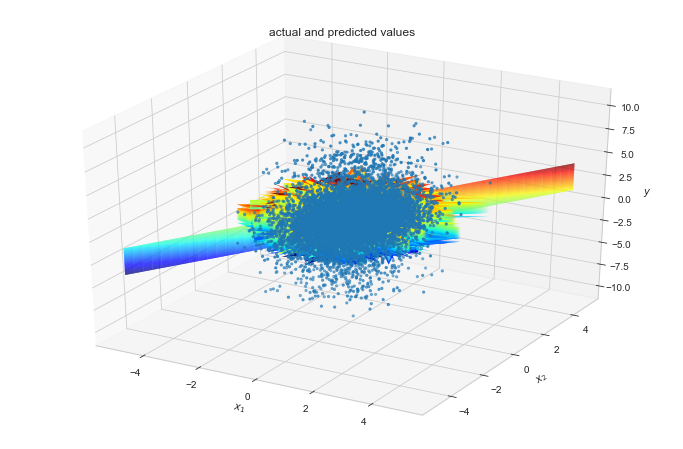

In [158]:
#predict y_hat
mesh1,mesh2 = np.meshgrid(x1_sort,x2_sort,indexing='ij')
y_plane = beta_hat[0]+beta_hat[1]*mesh1+beta_hat[2]*mesh2

# alternative plane
x1_alt = np.linspace(-5,5,100) 
x2_alt = np.linspace(-5,5,100)
mesh1_alt,mesh2_alt = np.meshgrid(x1_alt,x2_alt,indexing='ij')
y_plane_alt = beta_hat[0]+beta_hat[1]*mesh1_alt+beta_hat[2]*mesh2_alt

# plot the prediction vs. the data points
plt.style.use('seaborn-whitegrid')

fig_reg = plt.figure(figsize=(12,8))
ax = fig_reg.add_subplot(1,1,1,projection='3d')
ax.scatter(x1,x2,y,s=5)
ax.plot_surface(x1,x2,y_plane,cmap=cm.jet)
ax.plot_surface(x1_alt,x2_alt,y_plane_alt,cmap=cm.jet)

ax.set_title('actual and predicted values')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$');

In [14]:
#check planes
y_plane_alt[0,0]

-3.885671397073891

In [16]:
#check planes
y_plane[0,0]
#0.1+0.3*5+0.5*5

-2.7818547911787026

**Question 3:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [75]:
def sum_of_squares(beta):
    """
    Arguments: 
        beta: vector of beta coefficients
        
    Returns:
        the sum of squares of the data generating process
    
    """
    return np.sum(np.square(y-(beta[0]+beta[1]*x1+beta[2]*x2)))


In [82]:
# initial guess
beta_guess = [1,1,1]

#minimize sum of squares
ols = optimize.minimize(sum_of_squares,x0=beta_guess,method='SLSQP')

#unpack betas
beta_0_ols = ols.x[0]
beta_1_ols = ols.x[1]
beta_2_ols = ols.x[2]

print(f' beta0 = {beta_0_ols:.2f}, beta1 = {beta_1_ols:.2}, beta3 = {beta_2_ols:.2f}')

 beta0 = 0.10, beta1 = 0.29, beta3 = 0.50


**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [83]:
# define new loss function
def least_abs_dev(beta):
    """
    Arguments: 
        beta: vector of beta coefficients
        
    Returns:
        the least absolute deviations of the data generating process
    
    """
    return np.sum(np.abs(y-(beta[0]+beta[1]*x1+beta[2]*x2)))

#minimize sum of squares
lad = optimize.minimize(least_abs_dev,x0=beta_guess,method='SLSQP')

#unpack betas
beta_0_lad = lad.x[0]
beta_1_lad = lad.x[1]
beta_2_lad = lad.x[2]

print(f' beta0 = {beta_0_lad:.2f}, beta1 = {beta_1_lad:.2}, beta3 = {beta_2_lad:.2f}')

 beta0 = 0.09, beta1 = 0.31, beta3 = 0.51


**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

In [130]:
# intialise
N = 50
K = 5000
seed = 2020

beta0_ols_vec = np.empty(K)
beta1_ols_vec = np.empty(K)
beta2_ols_vec = np.empty(K)

beta0_lad_vec = np.empty(K)
beta1_lad_vec = np.empty(K)
beta2_lad_vec = np.empty(K)


# run monte carlo
for k in range(K):
    # run DGP
    x1,x2,y = DGP(N)
    
    # find betas
    ols = optimize.minimize(sum_of_squares,x0=beta_guess,method='SLSQP')
    lad = optimize.minimize(least_abs_dev,x0=beta_guess,method='SLSQP')
    
    # store betas
    beta0_ols_vec[k] = ols.x[0]
    beta1_ols_vec[k] = ols.x[1]
    beta2_ols_vec[k] = ols.x[2]
    
    beta0_lad_vec[k] = lad.x[0]
    beta1_lad_vec[k] = lad.x[1]
    beta2_lad_vec[k] = lad.x[2]

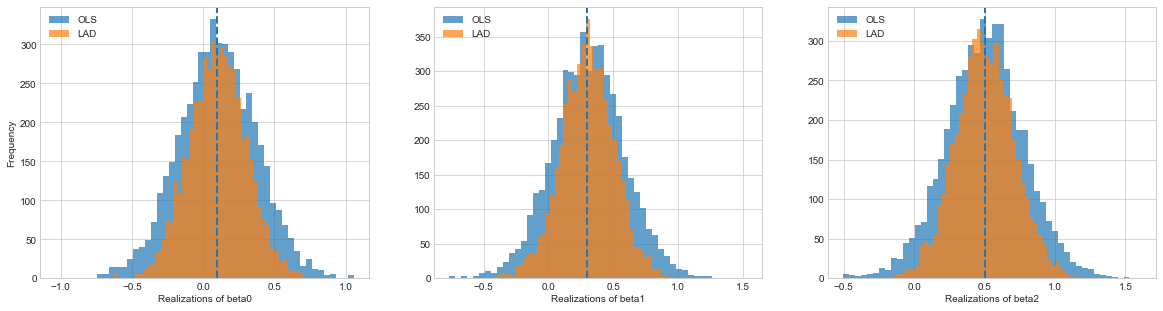

In [131]:
# plot the simulation results
fig_mc, ax_mc = plt.subplots(ncols=3,figsize=(20,5))

ax_mc[0].hist(beta0_ols_vec,bins=50,alpha=0.7,label='OLS')
ax_mc[0].hist(beta0_lad_vec,bins=50,alpha=0.7, label='LAD')
ax_mc[0].axvline(0.1,linestyle='dashed',linewidth=2)
ax_mc[0].set_ylabel('Frequency')
ax_mc[0].legend(loc='upper left')
ax_mc[0].set_xlabel('Realizations of beta0');

ax_mc[1].hist(beta1_ols_vec,bins=50,alpha=0.7,label='OLS')
ax_mc[1].hist(beta1_lad_vec,bins=50,alpha=0.7, label='LAD')
ax_mc[1].axvline(0.3,linestyle='dashed',linewidth=2)
ax_mc[1].legend(loc='upper left')
ax_mc[1].set_xlabel('Realizations of beta1');

ax_mc[2].hist(beta2_ols_vec,bins=50,alpha=0.7,label='OLS')
ax_mc[2].hist(beta2_lad_vec,bins=50,alpha=0.7, label='LAD')
ax_mc[2].axvline(0.5,linestyle='dashed',linewidth=2)
ax_mc[2].legend(loc='upper left')
ax_mc[2].set_xlabel('Realizations of beta2');

plt.show()

The above figure shows the realizations of the MC simulation of the DGP. Both methods are unbiased, but it seems the consistency of LAD is better than for OLS. Therefore we would choose LAD as our preferred method. 

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [54]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9 # should be 0.9

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

In [55]:
# value function
def v2(c,m2,d,alpha,chi,rho):
    x = m2-c
    return (c**(alpha)*(d+chi*x)**(1-alpha))**(1-rho)/(1-rho)

The **solution function for period 2** is:

In [56]:
def solve_period_2(alpha,chi,rho):

    # a. grids
    v2_grid = np.empty((100,100))
    c2_grid = np.empty((100,100))
    x_grid = np.empty((100,100))

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):

            # i. objective
            obj = lambda c2: -v2(c2,d,m2,alpha,chi,rho)

            # ii. initial value (consume third)
            x0 = m2/3

            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x
            x_grid[i,j] = m2-result.x
        
    return v2_grid,c2_grid,x_grid

Now we can unpack the solution and plot the functions:

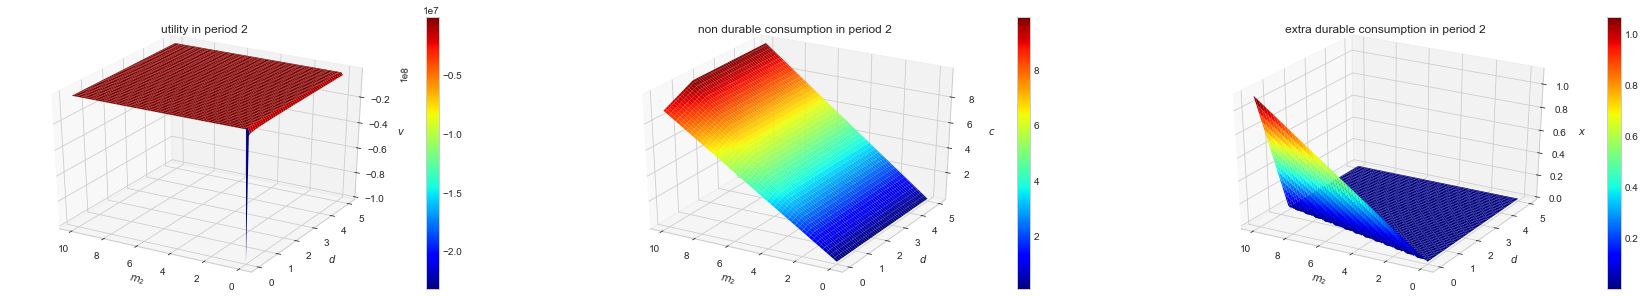

In [57]:
# a. solve
v2_grid,c2_grid,x_grid = solve_period_2(alpha,chi,rho)

# b. grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

# c. main figure
fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1,3,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,v2_grid,cmap=cm.jet)

# d. add labels
ax.set_title('utility in period 2')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$v$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

ax = fig.add_subplot(1,3,2,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,c2_grid,cmap=cm.jet)

# d. add labels
ax.set_title('non durable consumption in period 2')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$c$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

ax = fig.add_subplot(1,3,3,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,x_grid,cmap=cm.jet)

# d. add labels and title
ax.set_title('extra durable consumption in period 2')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$x$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

**Comment:** We see from the plof of $x$ that for extra durable good consumption to be positive, the consumer must have a relatively high amount of cash on hand and/or a relatively low amount of initial durable good consumption. This makes good sense, as the marginal utility from consumption in period 2 ($\alpha=0.8)$ is considerably higher than the marginal utility of durable good consumption ($1-\alpha=0.2$). The kink in the x function is, in a sense, mirrored in the consumption function, as the consumer for a relatively high amount of $d$ spends its full cash endowment on consumption.

The plot of $v$ is not that easy to interpret. This is due to a property of the utility function (more precisely the "Cobb-Douglas part"), which tends towards negative infinity for very low values of $d$ and $m_2$. Hence, it is difficult to see that there actually is a change in the dark red area as it appears flat. One workaround is to adjust the starting point of the `np.linspace()` vectors, such that  values very close to zero are excluded. We do this below. 

In [23]:
# check if all of m2 is used for consumption for d approximately 2.5
np.allclose(m2_vec[99],c2_grid[99,50])

True

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

In [58]:
# basic function
def v1(m1,d,Delta,r,beta,v2_interp):
    a = m1-d
    
    # a. v2 value, if low income
    m2_low = (1+r)*a+(1-Delta)
    v2_low = v2_interp([m2_low,d])[0]
    
    # b. v2 value, if mid income
    m2_mid = (1+r)*a+1
    v2_mid = v2_interp([m2_mid,d])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*a+(1+Delta)
    v2_high = v2_interp([m2_high,d])[0]
    
    # c. expected v2 value
    v2_exp = 1/3*v2_low+ 1/3*v2_mid+ 1/3*v2_high
    
    v1 = beta*v2_exp
    
    # d. total value
    return v1

#def v1(m1,r,beta,Delta,v2_interp,d):
 #   return (-w(m1,r,beta,Delta,v2_interp,d))

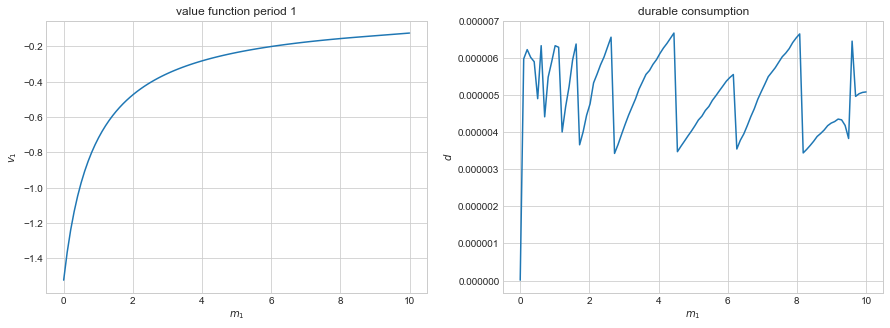

In [59]:
# a. define solve function
def solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    v1_vec = np.empty(100)
    d1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda d: -v1(m1,d,Delta,r,beta,v2_interp)
        
        # ii. initial guess (durable consume half)
        x0 = [m1/2]
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded', bounds=(1e-8,m1))
        
        # iv. save
        v1_vec[i] = -result.fun
        d1_vec[i] = result.x
     
    return v1_vec,d1_vec

# b. construct interpolator
v2_interp = interpolate.RegularGridInterpolator((m2_vec,d_vec),v2_grid,
                                                bounds_error=False,fill_value=None)
    
# c. solve period 1
v1_vec,d1_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp)


# d. plot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_vec,v1_vec)
ax.set_title('value function period 1')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v_1$');

ax = fig.add_subplot(1,2,2)
ax.plot(m1_vec,d1_vec)
ax.set_title('durable consumption')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$d$');

**Comment:**

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [5]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

In [159]:
def w(m0,d0,Delta,r,beta,v2_interp):
    
    a = m0-d
    
    # a. v2 value, if low income
    m2_low = (1+r)*a+(1-Delta)
    v2_low = v2_interp([m2_low,d])[0]
    
    # b. v2 value, if mid income
    m2_mid = (1+r)*a+1
    v2_mid = v2_interp([m2_mid,d])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*a+(1+Delta)
    v2_high = v2_interp([m2_high,d])[0]
    
    # c. expected v2 value
    v2_exp = 1/3*v2_low+ 1/3*v2_mid+ 1/3*v2_high
    
    v1 = beta*v2_exp
    
    # d. total value
    return v1    
    
#def solve_period_0

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

In [160]:
def _rosen(x1,x2):
    return 0.5*(1.0-x1)**2+(x2-x1**2)**2
def rosen(x):
    return _rosen(x[0],x[1])
def rosen_jac(x):
    return np.array([-(1.0-x[0])-4*x[0]*(x[1]-x[0]**2),2*(x[1]-x[0]**2)])
def rosen_hess(x):
    return np.array([[1-4*x[1]+12*x[0]**2,-4*x[0]],[-4*x[0],2]])

In [150]:
def gradient_descent(f,x0,jacx,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=1000): #step 1 ## HUSK ÆNDRE MAX ITER tilbage til 10k ##
    
    # step 2
    x = x0 # guess
    fx = f(x0[0],x0[1])
    it = 1 # iterations
    
    # step 3-10
    while it < max_iter:
        
        xprev = x
        fxprev = fx
    
        # step 3: compute numerical jacobian
        #num_jacx = jac(x) 
        
        #jac_array = np.array([f(x[0]+Delta,x[1])-f(x[0],x[1]),f(x[0],x[1]+Delta)-f(x[0],x[1])])
        #num_jacx = 1/Delta*jac_array
       
        jacx = rosen_jac(x)
    
    
        # step 4: check convergence
        if abs(np.max(jacx)) < epsilon:
            break
            
        else:
            theta = Theta # step 5:
            while True:

                # step 6: 
                f_theta = f(x[0]-theta*num_jacx[0],x[1]-theta*num_jacx[1])

                # step 7:
                if f_theta < fx:
                    break

                else:
                    # step 8: update theta
                    theta /= 2

        # step 9: update guess
        x = xprev - theta*jacx
                
        # step 10: 
        it += 1
                
    return x,it 

**Test case:**

In [151]:
#def rosen(x):
#    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

not implemented yet
